# Prelim

TO DO:
* `generate_submission()` needs to include opening pickled DF created in each fold and taking the mean of all of them,
* See if model would benefit from stacking
* Fill out EDA
* Create score csv
* Double check AUC plot generation
* Review ROC plot concepts

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import os
import json
import pickle
import glob

from xgboost import XGBClassifier
from sklearn.model_selection import KFold

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)             

In [ ]:
train_identity      = pd.read_csv('data/train_identity.csv')
train_transaction   = pd.read_csv('data/train_transaction.csv')
train               = train_transaction.merge(train_identity, on='TransactionID', how='outer')

In [ ]:
# Defining feature subsets

COLUMNS = list( train.columns ) 

V           = [x for x in COLUMNS if re.match('V+[0-9]*', x)]
C           = [x for x in COLUMNS if re.match('C+[0-9]*', x)]
D           = [x for x in COLUMNS if re.match('D+[0-9]*', x)]
M           = [x for x in COLUMNS if re.match('M+[0-9]*', x)]
ID          = [x for x in COLUMNS if re.match('id+_+[0-9]*', x)]
CARD        = [x for x in COLUMNS if re.match('card+[0-9]*', x)]

CATEGORIES  = list(train.select_dtypes(exclude=np.number).columns)

OTHER       = list( set(COLUMNS) - set(V + C + D + M + ID + CARD) )

FEATURE_CLASSES = {
    'V':           V, 
    'C':           C, 
    'D':           D ,
    'M':           M, 
    'ID':          ID,
    'CARD':        CARD,
    'other':       OTHER,
    'categories':  CATEGORIES
}

FE_kwargs = {
    'target_encoding'   : True,
    'category_encoding' : True
}

# EDA

# Helper Functions

In [1]:
# save model, loss plot, gain plot, 
def log_training(model, run_num):

    fold_num=0
    while os.path.exists('experiments/run%s/lossplot%s.png' % (run_num, fold_num) ):
        fold_num+=1

    # get results
    results         = model.evals_result()
    gain            = model.get_booster().get_score(importance_type='gain')

    # get top 15 features as measured by gain score for plot generation
    gain_sorted     = dict(sorted(gain.items(), key=lambda item: item[1]))
    keys            = list(gain_sorted.keys())[0:15]
    values          = list(gain_sorted.values())[0:15]

    # log gain in json - use later to get all features from model and top N
    with open('experiments/run%s/gain%s.json' % (run_num, fold_num), "w+") as json_file:
        json.dump(gain_sorted, json_file)
    
    # create gain plot
    plt.figure(figsize=(20,6))
    plt.bar(keys, values, color='skyblue')
    plt.xlabel('Keys')
    plt.ylabel('Values')
    plt.title('Dictionary Plot')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--')
    plt.savefig('experiments/run%s/gainplot%s.png' % (run_num, fold_num) )

    # create loss plot
    plt.figure(figsize=(10,7))
    plt.plot(results['validation_0']['auc'], label='Training AUC')
    plt.plot(results['validation_1']['auc'], label='Validation AUC')
    plt.title('Loss: run %s, split %s' % (run_num, fold_num))
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('experiments/run%s/lossplot%s.png' % (run_num, fold_num) )

    # save model
    with open('experiments/run%s/model%s.pkl' % (run_num, fold_num), mode='wb+') as file:
        pickle.dump(model, file)

# create submission as csv - predictions are created as mean across each model 
def generate_submission(run_num):

    sample_submission   = pd.read_csv('data/sample_submission.csv')
    test_identity       = pd.read_csv('data/test_identity.csv')
    test_transaction    = pd.read_csv('data/test_transaction.csv')
    test                = test_transaction.merge(test_identity, on='TransactionID', how='outer')

    test.rename( columns = lambda x: x.replace('id-', 'id_'), inplace=True )

    test = feature_engineering(test, run_num=run_num, split='test', category_encoding=True)

    df = pd.DataFrame()
    model_list = glob.glob('experiments/run%s/model*.pkl' % run_num)
    for i, model in enumerate(model_list):
        df[i] = pickle.load(open(model, "rb")).predict_proba(test)[:,1]

    sample_submission['isFraud'] = df.mean(axis=1)
    del df
    sample_submission.to_csv('submissions/submission_run%s.csv' % run_num, index=False)

# Feature Engineering

In [4]:
# encodes non-numeric values as numeric
def encode_categories(df):
    df[CATEGORIES] = df[CATEGORIES].astype('category').apply(lambda x: x.cat.codes)
    return df

# target encoding
def target_encoding(df):
    STATS = ["mean"]
    agg_features = df.groupby(CARD).isFraud.agg(STATS)
    agg_features.columns = [f"TE_CARD_{s}" for s in STATS]
    df = df.merge(agg_features, on=CARD, how='left')
    return df

# # adds average of features, weighted by relative gain importance
# def add_weighted_avg(data, feature_list_dict):
#     for k,v in feature_list_dict.items():
#         features = data[v]
#         gain = gain_sub3[v]
#         data[k] = features.fillna(0).dot( gain.transpose() ).div( gain.dot( gain.transpose() ))

# # adds quadratic terms in top n features: e.g. x_1, x_2, x_3 are added as x_1 **2, x_1 * x_2, x_1 * x_3, ..., x_2 * x_3. 
# # using n features adds 2 * (n choose 2)new features.
# def add_products(data, feature_list):
#     pairs = list(itertools.product(feature_list, feature_list))
#     for pair in pairs:
#         data[str(pair[0] + "*" + pair[1])] = data[pair[0]] * data[pair[1]]



In [21]:
def feature_engineering(df, split, **kwargs):
    fold_num        = kwargs.get('fold_num')
    run_num         = kwargs.get('run_num')
    target_enc      = kwargs.get('target_encoding')
    category_enc    = kwargs.get('category_encoding')

    if category_enc:
        df = encode_categories(df)

    ### TRAINING ###
    if split == 'train':
        if target_enc:
            df = target_encoding(df)

        df.drop(columns=['isFraud']).to_pickle('experiments/run%s/X_train_%s.pkl' % (run_num, fold_num))
    
    ### VALIDATION ###
    elif split == 'val':
        trained = pd.read_pickle('experiments/run%s/X_train_%s.pkl' % (run_num, fold_num))
        diff_cols = trained.columns.difference(df.columns)
        df = pd.merge(df, trained[diff_cols], left_index=True, right_index=True, how='right')
    

    ### TESTING ###
    elif split == 'test':
        trained = []
        for i in range(5):
            trained.append(pd.read_pickle('experiments/run%s/X_train_%s.pkl' % (run_num, i)))
        
        
        averages = pd.concat(trained).groupby('TransactionID').mean()
        diff_cols = trained[0].columns.difference(df.columns)
        df = pd.merge(df, averages[diff_cols], left_index=True, right_index=True, how='left')
        #df = pd.concat([df, averages], axis=1)

    try:
        df.drop(columns=['isFraud'], inplace=True)
    except KeyError:
        pass

    return df

# Training

[0]	validation_0-auc:0.85690	validation_1-auc:0.60469
[1]	validation_0-auc:0.85693	validation_1-auc:0.60673
[2]	validation_0-auc:0.88533	validation_1-auc:0.62434
[3]	validation_0-auc:0.88770	validation_1-auc:0.63235
[4]	validation_0-auc:0.88803	validation_1-auc:0.63414
[5]	validation_0-auc:0.88811	validation_1-auc:0.63489
[6]	validation_0-auc:0.88842	validation_1-auc:0.63511
[7]	validation_0-auc:0.88851	validation_1-auc:0.63491
[8]	validation_0-auc:0.88859	validation_1-auc:0.63498
[9]	validation_0-auc:0.88852	validation_1-auc:0.63484
[10]	validation_0-auc:0.88843	validation_1-auc:0.63456
[11]	validation_0-auc:0.88906	validation_1-auc:0.63516
[12]	validation_0-auc:0.88923	validation_1-auc:0.63483
[13]	validation_0-auc:0.88933	validation_1-auc:0.63457
[14]	validation_0-auc:0.88992	validation_1-auc:0.63426
[15]	validation_0-auc:0.89010	validation_1-auc:0.63404
[16]	validation_0-auc:0.89008	validation_1-auc:0.63344
[17]	validation_0-auc:0.89301	validation_1-auc:0.64997
[18]	validation_0-au

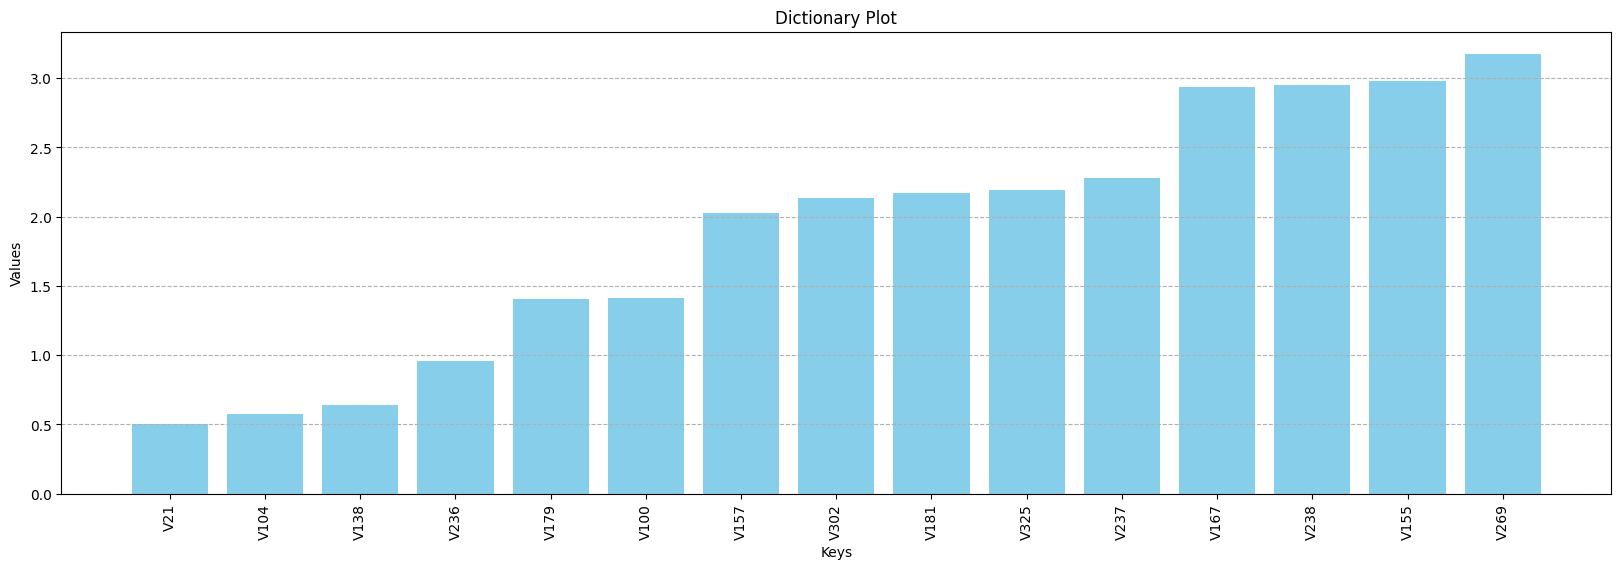

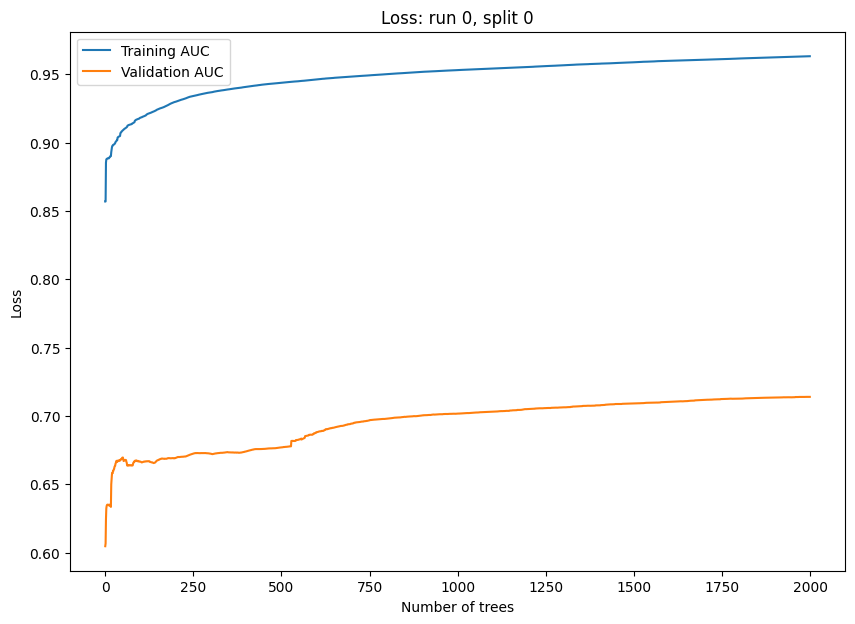

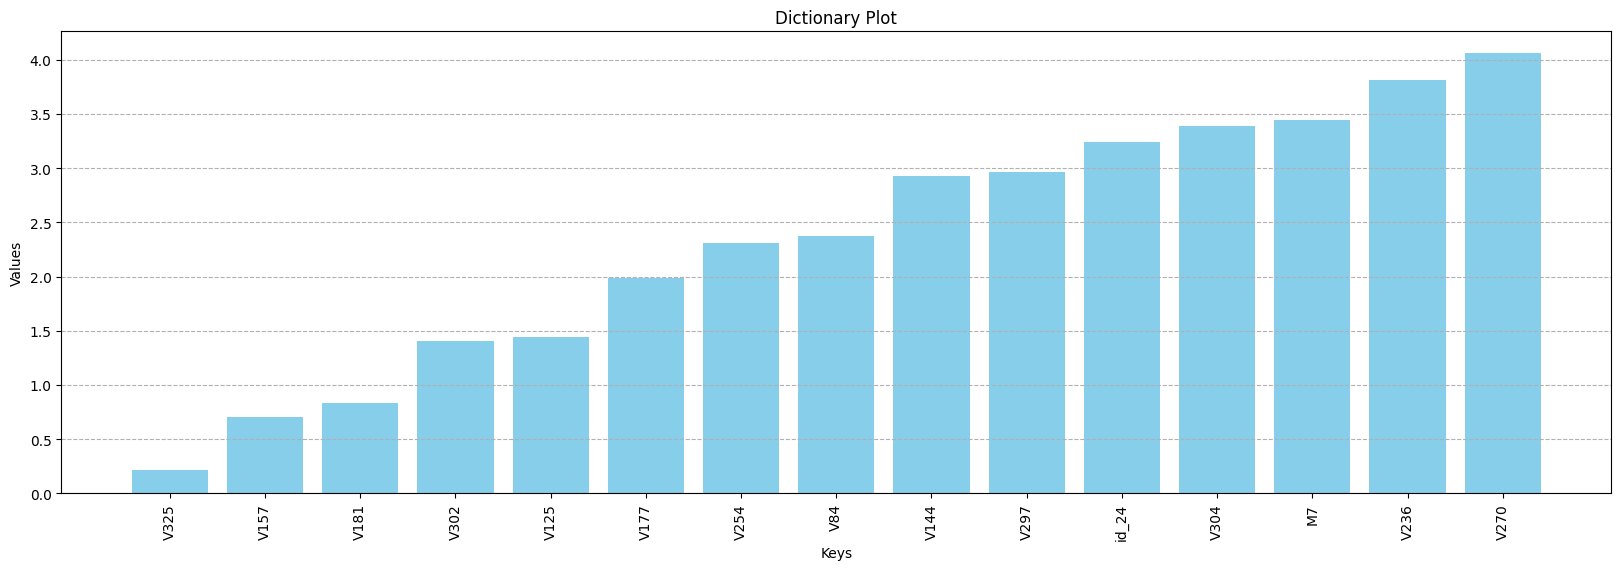

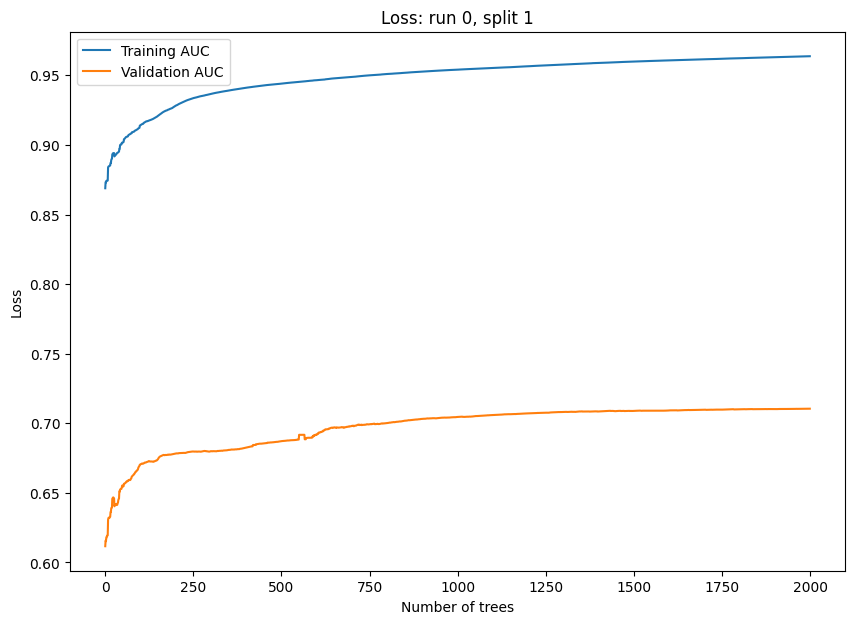

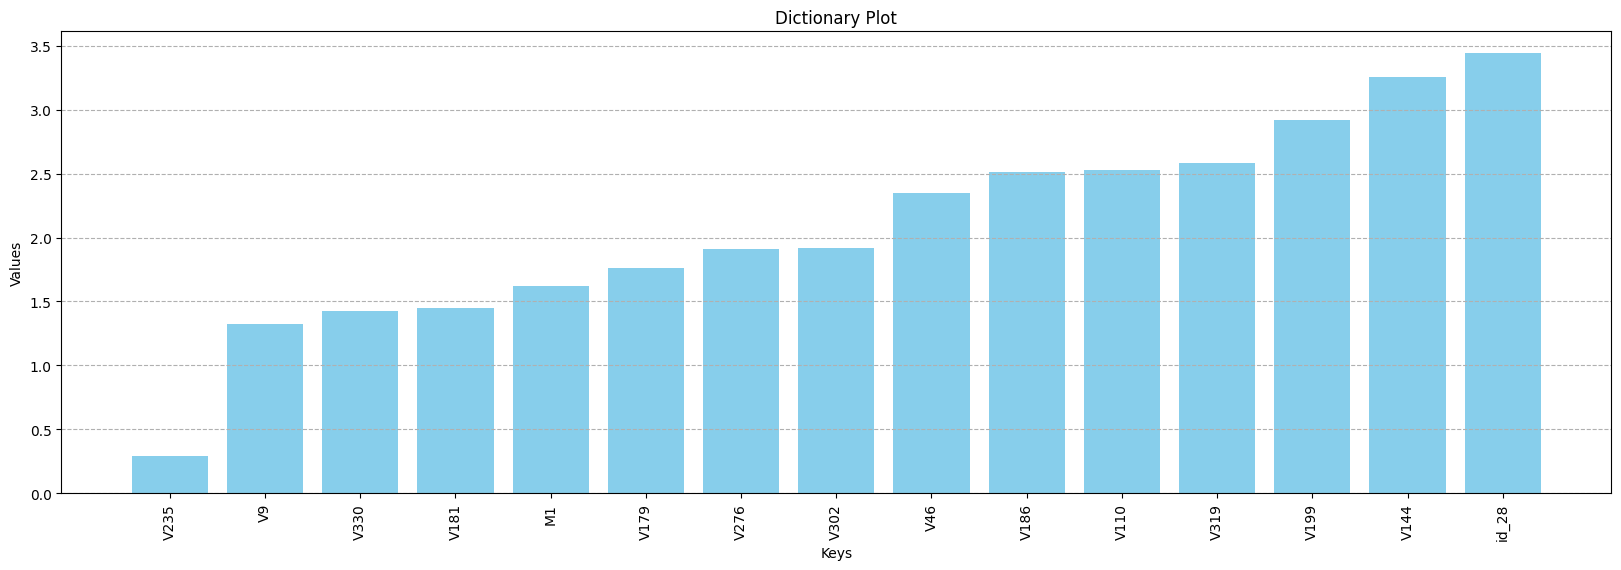

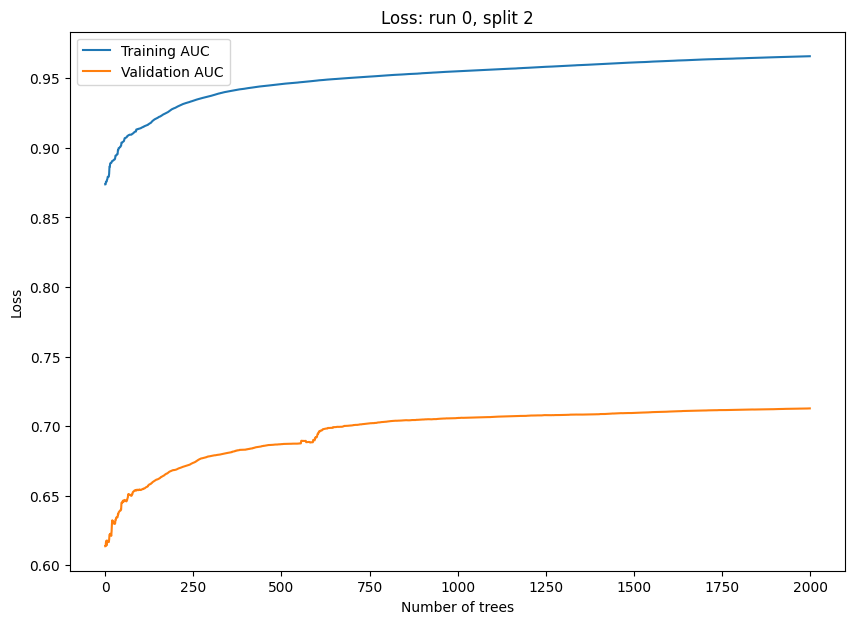

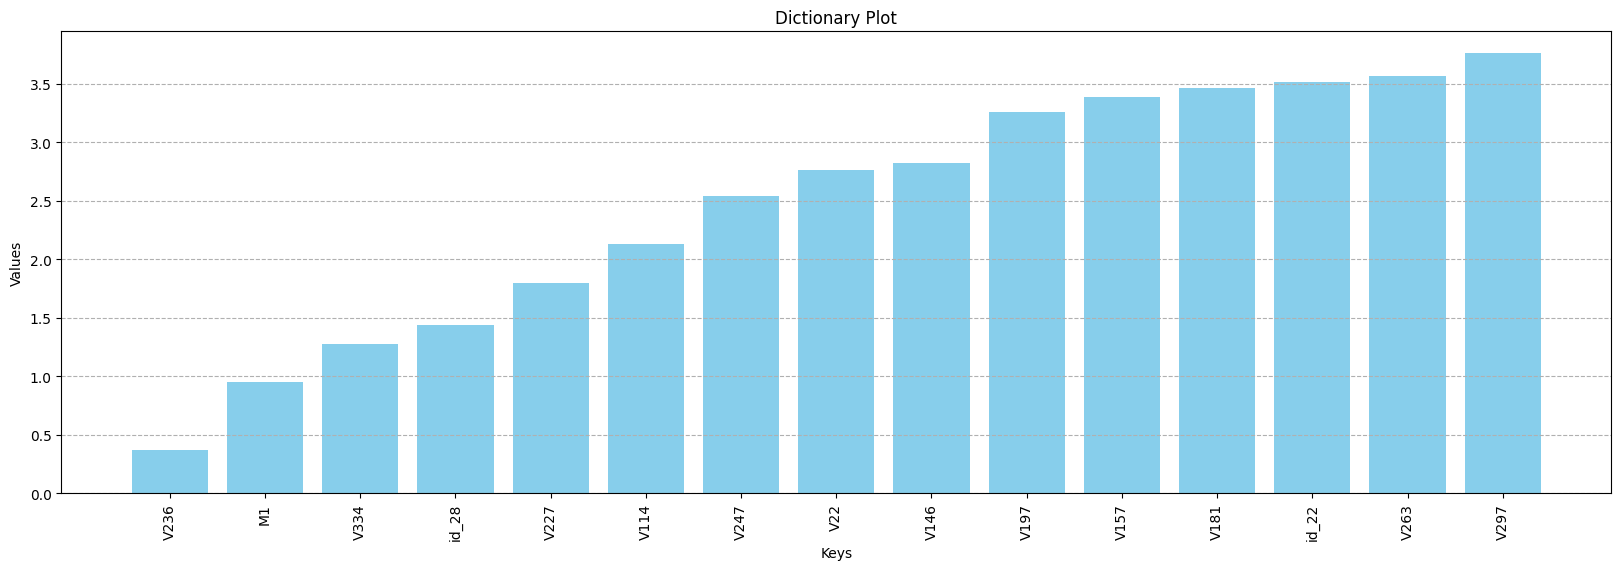

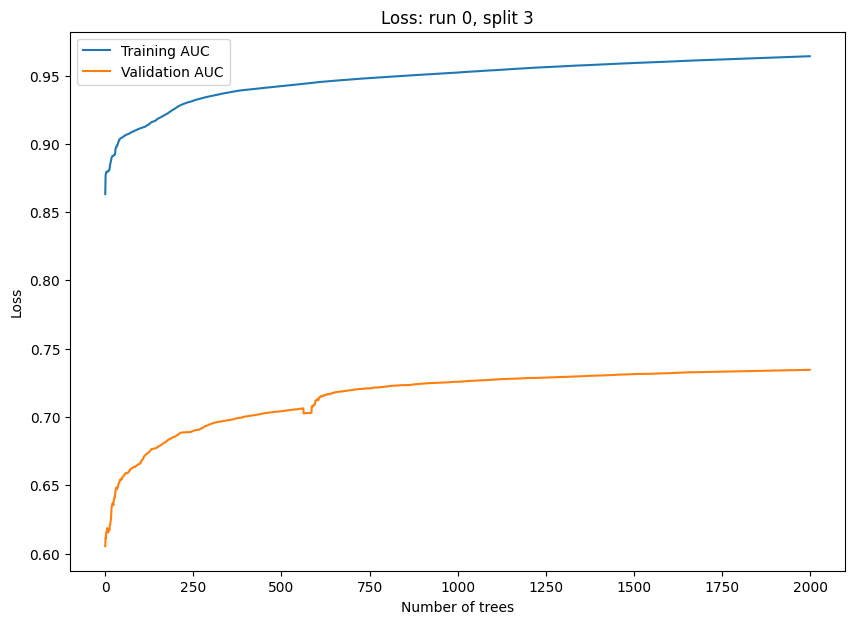

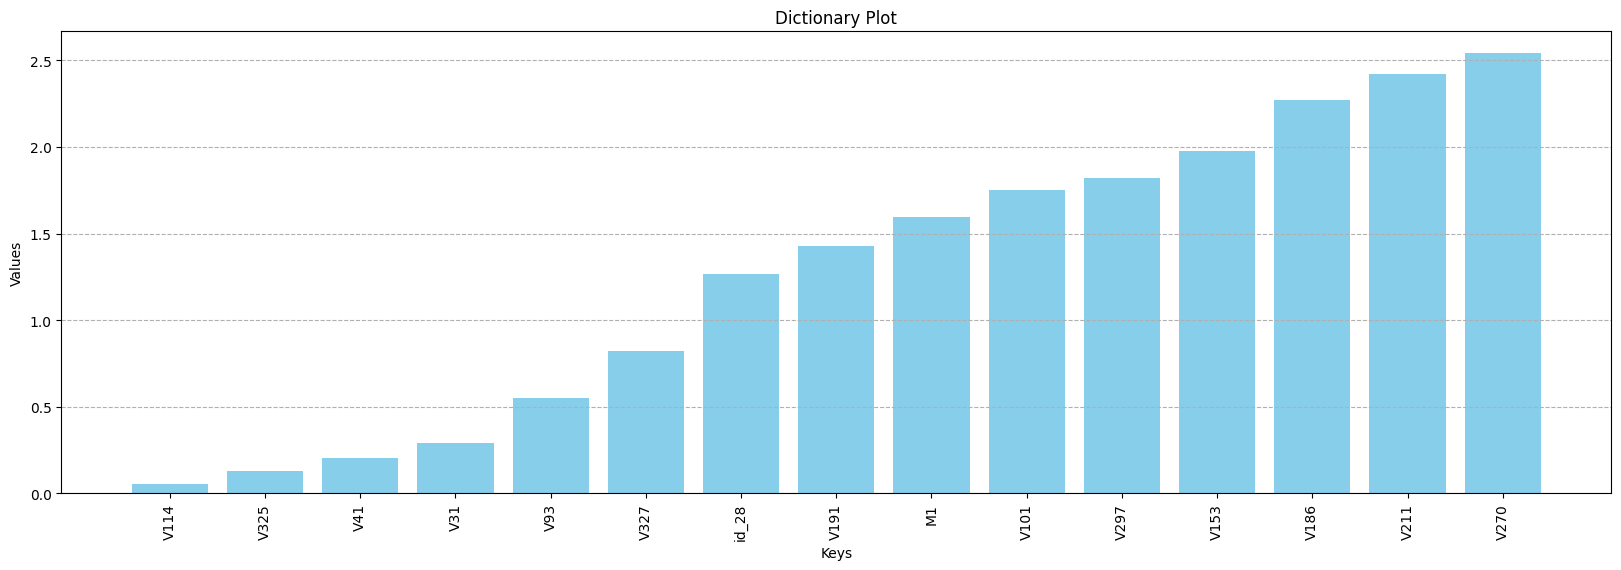

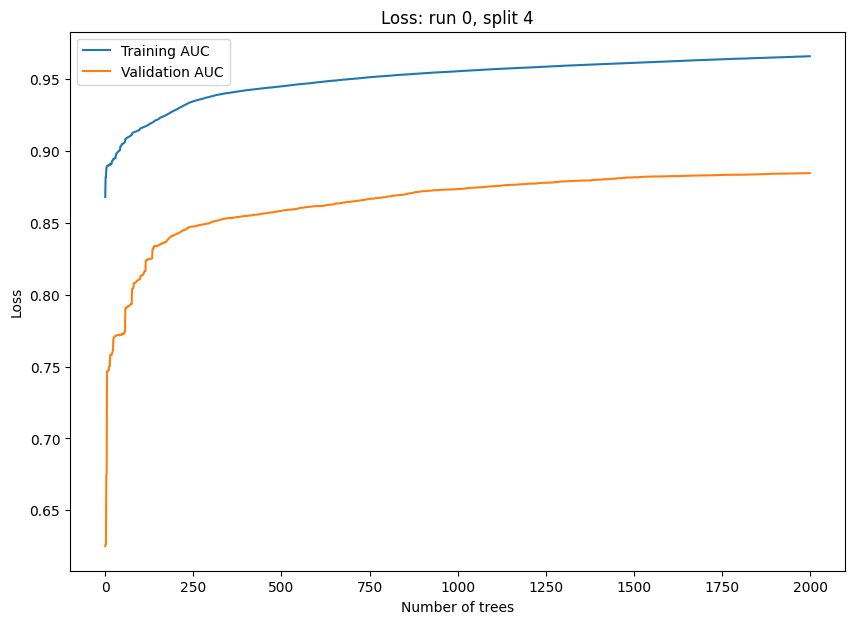

In [ ]:
# create experiment directory
run_num=0
while os.path.exists('experiments/run%s' % run_num):
    run_num+=1
os.mkdir('experiments/run%s' % run_num)

# grab data to be altered
X = train.copy(deep=True)
y = train['isFraud'].copy(deep=True)

model = XGBClassifier( 
        device="cuda",
        max_depth=6,  
        # subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric='auc'
)

kf = KFold(n_splits=5)
for fold_num, (train_index, val_index) in enumerate(kf.split(X)):
    FE_kwargs.update({ 'fold_num' : fold_num, 'run_num' : run_num })

    final_AUC_train = []
    final_AUC_val = []

    X_train     = X.iloc[train_index]
    X_val       = X.iloc[val_index]
    y_train     = y.iloc[train_index]
    y_val       = y.iloc[val_index]

    X_train     = feature_engineering( X_train,  split = 'train',  **FE_kwargs)
    X_val       = feature_engineering( X_val, split='val', **FE_kwargs)

    model.fit(
        X_train, 
        y_train,  
        eval_set=[(X_train, y_train), (X_val, y_val)]
        ) 

    log_training(model, run_num)

    results = model.evals_result()
    final_AUC_train.append( results['validation_0']['auc'][-1] )
    final_AUC_val.append( results['validation_1']['auc'][-1] )

mean_train_AUC = sum(final_AUC_train) / len(final_AUC_train)
mean_val_AUC = sum(final_AUC_val) / len(final_AUC_val)
print('Average errors: Training %s, Validation %s' % (mean_train_AUC, mean_val_AUC ))

# update spreadsheet with run scores so far
current_scores = pd.DataFrame()
current_scores['run'] = [run_num]
current_scores['mean_train_AUC'] = [mean_train_AUC]
current_scores['mean_val_AUC'] = [mean_val_AUC]
scores = pd.read_csv('experiments/average_scores.csv')
scores = pd.concat([scores, current_scores])
scores.to_csv('experiments/average_scores.csv', index=False)